<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/SAM_DeTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone DeTR Repo:

In [1]:
!git clone https://github.com/facebookresearch/detr.git
%cd detr

Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Total 263 (delta 0), reused 0 (delta 0), pack-reused 263
Receiving objects: 100% (263/263), 12.88 MiB | 22.50 MiB/s, done.
Resolving deltas: 100% (122/122), done.
/content/detr


Downlaod Requirements:

In [2]:
import gdown

# download model
url = 'https://drive.google.com/uc?id=1S59Aovb4dNOjsu_YdDLxz5wzpxwzww7p'
output = 'eval.zip'
gdown.download(url, output, quiet=True)

!unzip -q eval.zip

url = 'https://drive.google.com/uc?id=1ycUjt29WI4VjK6grZnQXYdzdEuMhpqNA'
gdown.download(url, 'raw_img.jpg', quiet=True)

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
!pip -q install 'git+https://github.com/facebookresearch/segment-anything.git'

Replace Backbone ResNet with SAM encoder:

In [10]:
%cd /content/detr
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
"""
Backbone modules.
"""
from collections import OrderedDict

import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torchvision.models._utils import IntermediateLayerGetter
from typing import Dict, List

from util.misc import NestedTensor, is_main_process

from models.position_encoding import build_position_encoding
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

class FrozenBatchNorm2d(torch.nn.Module):
    """
    BatchNorm2d where the batch statistics and the affine parameters are fixed.

    Copy-paste from torchvision.misc.ops with added eps before rqsrt,
    without which any other models than torchvision.models.resnet[18,34,50,101]
    produce nans.
    """

    def __init__(self, n):
        super(FrozenBatchNorm2d, self).__init__()
        self.register_buffer("weight", torch.ones(n))
        self.register_buffer("bias", torch.zeros(n))
        self.register_buffer("running_mean", torch.zeros(n))
        self.register_buffer("running_var", torch.ones(n))

    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                              missing_keys, unexpected_keys, error_msgs):
        num_batches_tracked_key = prefix + 'num_batches_tracked'
        if num_batches_tracked_key in state_dict:
            del state_dict[num_batches_tracked_key]

        super(FrozenBatchNorm2d, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict,
            missing_keys, unexpected_keys, error_msgs)

    def forward(self, x):
        # move reshapes to the beginning
        # to make it fuser-friendly
        w = self.weight.reshape(1, -1, 1, 1)
        b = self.bias.reshape(1, -1, 1, 1)
        rv = self.running_var.reshape(1, -1, 1, 1)
        rm = self.running_mean.reshape(1, -1, 1, 1)
        eps = 1e-5
        scale = w * (rv + eps).rsqrt()
        bias = b - rm * scale
        return x * scale + bias


class BackboneBase(nn.Module):

    def __init__(self, backbone: nn.Module, train_backbone: bool, num_channels: int, return_interm_layers: bool):
        super().__init__()
        for name, parameter in backbone.named_parameters():
            if not train_backbone or 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
                parameter.requires_grad_(False)
        if return_interm_layers:
            return_layers = {"layer1": "0", "layer2": "1", "layer3": "2", "layer4": "3"}
        else:
            return_layers = {'layer4': "0"}
        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        self.num_channels = num_channels
        sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
        sam.eval()
        for param in sam.image_encoder.parameters():
            param.requires_grad = False
        self.sam_encoder = sam.image_encoder


    def forward(self, tensor_list: NestedTensor):
        print('tensor_list.tensors', tensor_list.tensors.shape)
        # xs = self.body(tensor_list.tensors)
        xs = OrderedDict()
        xs['0'] = self.sam_encoder(tensor_list.tensors)
        print('out sam encoder', xs['0'].shape)
        out: Dict[str, NestedTensor] = {}
        for name, x in xs.items():
            m = tensor_list.mask
            print('m', m.shape)
            assert m is not None
            mask = F.interpolate(m[None].float(), size=x.shape[-2:]).to(torch.bool)[0]
            print('mobarak',name, x.shape, mask.shape)
            out[name] = NestedTensor(x, mask)
        return out


class Backbone(BackboneBase):
    """ResNet backbone with frozen BatchNorm."""
    def __init__(self, name: str,
                 train_backbone: bool,
                 return_interm_layers: bool,
                 dilation: bool):
        backbone = getattr(torchvision.models, name)(
            replace_stride_with_dilation=[False, False, dilation],
            pretrained=is_main_process(), norm_layer=FrozenBatchNorm2d)
        num_channels = 512 if name in ('resnet18', 'resnet34') else 2048
        super().__init__(backbone, train_backbone, num_channels, return_interm_layers)


class Joiner(nn.Sequential):
    def __init__(self, backbone, position_embedding):
        super().__init__(backbone, position_embedding)

    def forward(self, tensor_list: NestedTensor):
        xs = self[0](tensor_list)
        out: List[NestedTensor] = []
        pos = []
        for name, x in xs.items():
            out.append(x)
            # position encoding
            pos.append(self[1](x).to(x.tensors.dtype))

        return out, pos


def build_backbone(args):
    position_embedding = build_position_encoding(args)
    train_backbone = args.lr_backbone > 0
    return_interm_layers = args.masks
    backbone = Backbone(args.backbone, train_backbone, return_interm_layers, args.dilation)
    model = Joiner(backbone, position_embedding)
    model.num_channels = backbone.num_channels
    return model


/content/detr


Minor Edit on DeTR Builder:

In [13]:
%cd /content/detr
import torch
import torch.nn.functional as F
from torch import nn
from util import box_ops
from util.misc import (NestedTensor, nested_tensor_from_tensor_list,
                       accuracy, get_world_size, interpolate,
                       is_dist_avail_and_initialized)

# from models.backbone import build_backbone
from models.matcher import build_matcher
from models.segmentation import (DETRsegm, PostProcessPanoptic, PostProcessSegm,
                           dice_loss, sigmoid_focal_loss)
from models.transformer import build_transformer


class SetCriterion(nn.Module):
    """ This class computes the loss for DETR.
    The process happens in two steps:
        1) we compute hungarian assignment between ground truth boxes and the outputs of the model
        2) we supervise each pair of matched ground-truth / prediction (supervise class and box)
    """
    def __init__(self, num_classes, matcher, weight_dict, eos_coef, losses):
        """ Create the criterion.
        Parameters:
            num_classes: number of object categories, omitting the special no-object category
            matcher: module able to compute a matching between targets and proposals
            weight_dict: dict containing as key the names of the losses and as values their relative weight.
            eos_coef: relative classification weight applied to the no-object category
            losses: list of all the losses to be applied. See get_loss for list of available losses.
        """
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, outputs, targets, indices, num_boxes, log=True):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {'loss_ce': loss_ce}

        if log:
            # TODO this should probably be a separate loss, not hacked in this one here
            losses['class_error'] = 100 - accuracy(src_logits[idx], target_classes_o)[0]
        return losses

    @torch.no_grad()
    def loss_cardinality(self, outputs, targets, indices, num_boxes):
        """ Compute the cardinality error, ie the absolute error in the number of predicted non-empty boxes
        This is not really a loss, it is intended for logging purposes only. It doesn't propagate gradients
        """
        pred_logits = outputs['pred_logits']
        device = pred_logits.device
        tgt_lengths = torch.as_tensor([len(v["labels"]) for v in targets], device=device)
        # Count the number of predictions that are NOT "no-object" (which is the last class)
        card_pred = (pred_logits.argmax(-1) != pred_logits.shape[-1] - 1).sum(1)
        card_err = F.l1_loss(card_pred.float(), tgt_lengths.float())
        losses = {'cardinality_error': card_err}
        return losses

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        """Compute the losses related to the bounding boxes, the L1 regression loss and the GIoU loss
           targets dicts must contain the key "boxes" containing a tensor of dim [nb_target_boxes, 4]
           The target boxes are expected in format (center_x, center_y, w, h), normalized by the image size.
        """
        assert 'pred_boxes' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')

        losses = {}
        losses['loss_bbox'] = loss_bbox.sum() / num_boxes

        loss_giou = 1 - torch.diag(box_ops.generalized_box_iou(
            box_ops.box_cxcywh_to_xyxy(src_boxes),
            box_ops.box_cxcywh_to_xyxy(target_boxes)))
        losses['loss_giou'] = loss_giou.sum() / num_boxes
        return losses

    def loss_masks(self, outputs, targets, indices, num_boxes):
        """Compute the losses related to the masks: the focal loss and the dice loss.
           targets dicts must contain the key "masks" containing a tensor of dim [nb_target_boxes, h, w]
        """
        assert "pred_masks" in outputs

        src_idx = self._get_src_permutation_idx(indices)
        tgt_idx = self._get_tgt_permutation_idx(indices)
        src_masks = outputs["pred_masks"]
        src_masks = src_masks[src_idx]
        masks = [t["masks"] for t in targets]
        # TODO use valid to mask invalid areas due to padding in loss
        target_masks, valid = nested_tensor_from_tensor_list(masks).decompose()
        target_masks = target_masks.to(src_masks)
        target_masks = target_masks[tgt_idx]

        # upsample predictions to the target size
        src_masks = interpolate(src_masks[:, None], size=target_masks.shape[-2:],
                                mode="bilinear", align_corners=False)
        src_masks = src_masks[:, 0].flatten(1)

        target_masks = target_masks.flatten(1)
        target_masks = target_masks.view(src_masks.shape)
        losses = {
            "loss_mask": sigmoid_focal_loss(src_masks, target_masks, num_boxes),
            "loss_dice": dice_loss(src_masks, target_masks, num_boxes),
        }
        return losses

    def _get_src_permutation_idx(self, indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def _get_tgt_permutation_idx(self, indices):
        # permute targets following indices
        batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
        tgt_idx = torch.cat([tgt for (_, tgt) in indices])
        return batch_idx, tgt_idx

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'cardinality': self.loss_cardinality,
            'boxes': self.loss_boxes,
            'masks': self.loss_masks
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)

    def forward(self, outputs, targets):
        """ This performs the loss computation.
        Parameters:
             outputs: dict of tensors, see the output specification of the model for the format
             targets: list of dicts, such that len(targets) == batch_size.
                      The expected keys in each dict depends on the losses applied, see each loss' doc
        """
        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}

        # Retrieve the matching between the outputs of the last layer and the targets
        indices = self.matcher(outputs_without_aux, targets)

        # Compute the average number of target boxes accross all nodes, for normalization purposes
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)
        if is_dist_avail_and_initialized():
            torch.distributed.all_reduce(num_boxes)
        num_boxes = torch.clamp(num_boxes / get_world_size(), min=1).item()

        # Compute all the requested losses
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))

        # In case of auxiliary losses, we repeat this process with the output of each intermediate layer.
        if 'aux_outputs' in outputs:
            for i, aux_outputs in enumerate(outputs['aux_outputs']):
                indices = self.matcher(aux_outputs, targets)
                for loss in self.losses:
                    if loss == 'masks':
                        # Intermediate masks losses are too costly to compute, we ignore them.
                        continue
                    kwargs = {}
                    if loss == 'labels':
                        # Logging is enabled only for the last layer
                        kwargs = {'log': False}
                    l_dict = self.get_loss(loss, aux_outputs, targets, indices, num_boxes, **kwargs)
                    l_dict = {k + f'_{i}': v for k, v in l_dict.items()}
                    losses.update(l_dict)

        return losses


class PostProcess(nn.Module):
    """ This module converts the model's output into the format expected by the coco api"""
    @torch.no_grad()
    def forward(self, outputs, target_sizes):
        """ Perform the computation
        Parameters:
            outputs: raw outputs of the model
            target_sizes: tensor of dimension [batch_size x 2] containing the size of each images of the batch
                          For evaluation, this must be the original image size (before any data augmentation)
                          For visualization, this should be the image size after data augment, but before padding
        """
        out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']

        assert len(out_logits) == len(target_sizes)
        assert target_sizes.shape[1] == 2

        prob = F.softmax(out_logits, -1)
        scores, labels = prob[..., :-1].max(-1)

        # convert to [x0, y0, x1, y1] format
        boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
        # and from relative [0, 1] to absolute [0, height] coordinates
        img_h, img_w = target_sizes.unbind(1)
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
        boxes = boxes * scale_fct[:, None, :]

        results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]

        return results


class MLP(nn.Module):
    """ Very simple multi-layer perceptron (also called FFN)"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x


def build(args):
    # the `num_classes` naming here is somewhat misleading.
    # it indeed corresponds to `max_obj_id + 1`, where max_obj_id
    # is the maximum id for a class in your dataset. For example,
    # COCO has a max_obj_id of 90, so we pass `num_classes` to be 91.
    # As another example, for a dataset that has a single class with id 1,
    # you should pass `num_classes` to be 2 (max_obj_id + 1).
    # For more details on this, check the following discussion
    # https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223
    num_classes = 20 if args.dataset_file != 'coco' else 8
    if args.dataset_file == "coco_panoptic":
        # for panoptic, we just add a num_classes that is large enough to hold
        # max_obj_id + 1, but the exact value doesn't really matter
        num_classes = 250
    device = torch.device(args.device)

    backbone = build_backbone(args)

    transformer = build_transformer(args)
    model = DETR(
        backbone,
        transformer,
        num_classes=num_classes,
        num_queries=args.num_queries,
        aux_loss=args.aux_loss,
    )
    if args.masks:
        model = DETRsegm(model, freeze_detr=(args.frozen_weights is not None))
    matcher = build_matcher(args)
    weight_dict = {'loss_ce': 1, 'loss_bbox': args.bbox_loss_coef}
    weight_dict['loss_giou'] = args.giou_loss_coef
    if args.masks:
        weight_dict["loss_mask"] = args.mask_loss_coef
        weight_dict["loss_dice"] = args.dice_loss_coef
    # TODO this is a hack
    if args.aux_loss:
        aux_weight_dict = {}
        for i in range(args.dec_layers - 1):
            aux_weight_dict.update({k + f'_{i}': v for k, v in weight_dict.items()})
        weight_dict.update(aux_weight_dict)

    losses = ['labels', 'boxes', 'cardinality']
    if args.masks:
        losses += ["masks"]
    criterion = SetCriterion(num_classes, matcher=matcher, weight_dict=weight_dict,
                             eos_coef=args.eos_coef, losses=losses)
    criterion.to(device)
    postprocessors = {'bbox': PostProcess()}
    if args.masks:
        postprocessors['segm'] = PostProcessSegm()
        if args.dataset_file == "coco_panoptic":
            is_thing_map = {i: i <= 90 for i in range(201)}
            postprocessors["panoptic"] = PostProcessPanoptic(is_thing_map, threshold=0.85)

    return model, criterion, postprocessors

class DETR(nn.Module):
    """ This is the DETR module that performs object detection """
    def __init__(self, backbone, transformer, num_classes, num_queries, aux_loss=False):
        """ Initializes the model.
        Parameters:
            backbone: torch module of the backbone to be used. See backbone.py
            transformer: torch module of the transformer architecture. See transformer.py
            num_classes: number of object classes
            num_queries: number of object queries, ie detection slot. This is the maximal number of objects
                         DETR can detect in a single image. For COCO, we recommend 100 queries.
            aux_loss: True if auxiliary decoding losses (loss at each decoder layer) are to be used.
        """
        super().__init__()
        self.num_queries = num_queries
        self.transformer = transformer
        hidden_dim = transformer.d_model
        self.class_embed = nn.Linear(hidden_dim, num_classes + 1)
        self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)
        self.query_embed = nn.Embedding(num_queries, hidden_dim)
        # self.input_proj = nn.Conv2d(backbone.num_channels, hidden_dim, kernel_size=1)#mobarak
        self.input_proj = nn.Conv2d(256, hidden_dim, kernel_size=1)
        self.backbone = backbone
        self.aux_loss = aux_loss
        # sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
        # self.encoder_sam = sam.image_encoder

    def forward(self, samples: NestedTensor):
        """ The forward expects a NestedTensor, which consists of:
               - samples.tensor: batched images, of shape [batch_size x 3 x H x W]
               - samples.mask: a binary mask of shape [batch_size x H x W], containing 1 on padded pixels

            It returns a dict with the following elements:
               - "pred_logits": the classification logits (including no-object) for all queries.
                                Shape= [batch_size x num_queries x (num_classes + 1)]
               - "pred_boxes": The normalized boxes coordinates for all queries, represented as
                               (center_x, center_y, height, width). These values are normalized in [0, 1],
                               relative to the size of each individual image (disregarding possible padding).
                               See PostProcess for information on how to retrieve the unnormalized bounding box.
               - "aux_outputs": Optional, only returned when auxilary losses are activated. It is a list of
                                dictionnaries containing the two above keys for each decoder layer.
        """
        if isinstance(samples, (list, torch.Tensor)):
            samples = nested_tensor_from_tensor_list(samples)
        # sam_encoder_out = self.encoder_sam(samples.tensors)
        # print('sam_encoder_out:', sam_encoder_out.shape)
        print('samples:',samples.tensors.shape)
        features, pos = self.backbone(samples)
        print('features', features[0].tensors.shape)#[1, 2048, 32, 40]
        print('pos:', torch.stack(pos).shape)#[1, 1, 256, 32, 40]
        src, mask = features[-1].decompose()
        print('features src:', src.shape, 'features mask:', mask.shape)#torch.Size([1, 2048, 32, 40]), ([1, 32, 40])
        assert mask is not None

        print('Transformer inputs', 'self.input_proj(src):', self.input_proj(src).shape)#[1, 256, 32, 40]
        print( 'mask',mask.shape, 'embed weight:', self.query_embed.weight.shape)#[1, 32, 40], [100, 256]
        print('pos[-1]:', pos[-1].shape)#[1, 256, 32, 40]
        hs = self.transformer(self.input_proj(src), mask, self.query_embed.weight, pos[-1])[0]
        print('Transformer outputs', hs.shape)
        outputs_class = self.class_embed(hs)
        print('outputs_class', outputs_class.shape)
        outputs_coord = self.bbox_embed(hs).sigmoid()
        print('outputs_coord', outputs_coord.shape)
        out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_coord[-1]}
        # if self.aux_loss:
        #     out['aux_outputs'] = self._set_aux_loss(outputs_class, outputs_coord)
        return out

/content/detr


In [14]:
import argparse
from main import get_args_parser
from PIL import Image
# from models import build_model
import torchvision.transforms as T
import numpy as np

transform = T.Compose([
    T.ToTensor(),
    T.Resize((1024, 1024)),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


def main():
    parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
    args = parser.parse_args([])
    args.aux_loss = False
    args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(args.device)
    model, criterion, postprocessors = build(args)
    model.to(device)
    # model.load_state_dict(torch.load('eval_0049.pth', map_location=torch.device('cpu')).state_dict())
    # model = torch.load('eval_0049.pth', map_location=torch.device('cpu'))
    model.eval();

    raw_img = Image.open('raw_img.jpg')
    img = transform(raw_img).unsqueeze(0)
    outputs = model(img)
    print('outputs[pred_logits]:', outputs['pred_logits'].shape)
main()

samples: torch.Size([1, 3, 1024, 1024])
tensor_list.tensors torch.Size([1, 3, 1024, 1024])
out sam encoder torch.Size([1, 256, 64, 64])
m torch.Size([1, 1024, 1024])
mobarak 0 torch.Size([1, 256, 64, 64]) torch.Size([1, 64, 64])
features torch.Size([1, 256, 64, 64])
pos: torch.Size([1, 1, 256, 64, 64])
features src: torch.Size([1, 256, 64, 64]) features mask: torch.Size([1, 64, 64])
Transformer inputs self.input_proj(src): torch.Size([1, 256, 64, 64])
mask torch.Size([1, 64, 64]) embed weight: torch.Size([100, 256])
pos[-1]: torch.Size([1, 256, 64, 64])
Transformer outputs torch.Size([6, 1, 100, 256])
outputs_class torch.Size([6, 1, 100, 9])
outputs_coord torch.Size([6, 1, 100, 4])
outputs[pred_logits]: torch.Size([1, 100, 9])


Debugging output of DeTR with SAM Encoder Vs ResNet:

In [5]:
SAM Backbone:
samples: torch.Size([1, 3, 1024, 1024])
tensor_list.tensors torch.Size([1, 3, 1024, 1024])
out sam encoder torch.Size([1, 256, 64, 64])
m torch.Size([1, 1024, 1024])
mobarak 0 torch.Size([1, 256, 64, 64]) torch.Size([1, 64, 64])
features torch.Size([1, 256, 64, 64])
pos: torch.Size([1, 1, 256, 64, 64])
features src: torch.Size([1, 256, 64, 64]) features mask: torch.Size([1, 64, 64])
Transformer inputs self.input_proj(src): torch.Size([1, 256, 64, 64])
mask torch.Size([1, 64, 64]) embed weight: torch.Size([100, 256])
pos[-1]: torch.Size([1, 256, 64, 64])
Transformer outputs torch.Size([6, 1, 100, 256])
outputs_class torch.Size([6, 1, 100, 9])
outputs_coord torch.Size([6, 1, 100, 4])
outputs[pred_logits]: torch.Size([1, 100, 9])

ResNet Backbone:
samples: torch.Size([1, 3, 1024, 1024])
tensor_list.tensors torch.Size([1, 3, 1024, 1024])
out sam encoder torch.Size([1, 2048, 32, 32])
m torch.Size([1, 1024, 1024])
mobarak 0 torch.Size([1, 2048, 32, 32]) torch.Size([1, 32, 32])
features torch.Size([1, 2048, 32, 32])
pos: torch.Size([1, 1, 256, 32, 32])
features src: torch.Size([1, 2048, 32, 32]) features mask: torch.Size([1, 32, 32])
Transformer inputs self.input_proj(src): torch.Size([1, 256, 32, 32])
mask torch.Size([1, 32, 32]) embed weight: torch.Size([100, 256])
pos[-1]: torch.Size([1, 256, 32, 32])
Transformer outputs torch.Size([6, 1, 100, 256])
outputs_class torch.Size([6, 1, 100, 9])
outputs_coord torch.Size([6, 1, 100, 4])
outputs[pred_logits]: torch.Size([1, 100, 9])

4096

Play with SAM:<br>
We used SAM with vit_b which consist 12 multihead attention (MHA) block:<br>
model_type = "vit_b" = 12 MHA = !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth<br>

model_type = "vit_l" = 24 MHA = !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth<br>

model_type = "vit_h" = 32 MHA = !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pt<br>

To debug SAM edit the lib:<br>
/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/image_encoder.py<br>
/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/sam.py

In [16]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/content/detr/sam_vit_b_01ec64.pth"
model_type = "vit_b"

# device = "cuda"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
sam.eval()
#if you want to change the size:
# sam, img_embedding_size = sam_model_registry[model_type](image_size=img_size,
#                                     num_classes=num_classes,
#                                     checkpoint=sam_checkpoint, pixel_mean=[0, 0, 0],
#                                     pixel_std=[1, 1, 1])

mask_generator = SamAutomaticMaskGenerator(sam)

raw_img = Image.open('/content/detr/raw_img.jpg')
image = np.array(raw_img)
masks = mask_generator.generate(image)
print(masks[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


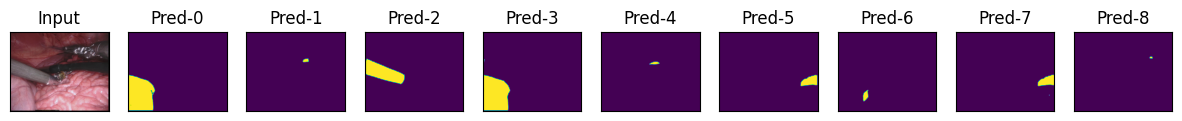

In [25]:
import matplotlib.pyplot as plt

num_img = len(masks)
num_img = 10
fig, ax = plt.subplots(1, num_img, figsize=(1.5*num_img,7), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(image)
ax[0].set_title('Input')
for i in range(num_img - 1):
    ax[i+1].imshow(masks[i]['segmentation'])
    ax[i+1].set_title('Pred-{}'.format(i))